This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## DeepDream

### Implementing DeepDream in Keras

**Fetching the test image**

440742/440742 [==============================] - 1s 3us/step


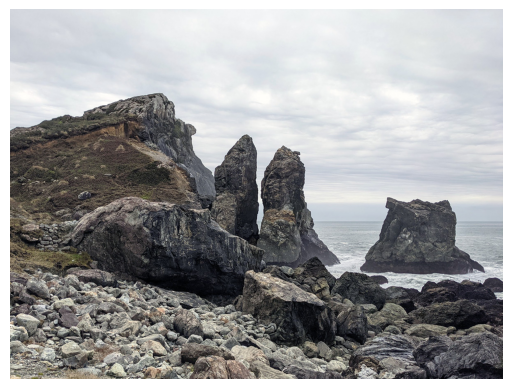

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

**Instantiating a pretrained `InceptionV3` model**

In [2]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 23s 0us/step


**Configuring the contribution of each layer to the DeepDream loss**

In [3]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
# 输出每一层的名字和结果
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
# 返回每个目标层的激活值
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

**The DeepDream loss**

In [4]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # 对靠近顶层的层的激活值的L2范数进行加权求和
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

**The DeepDream gradient ascent process**

In [5]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    # 计算DeepDream损失相对于当前图像的梯度
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    # L2规范化
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        # 更新图像，增大DeepDream损失
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [6]:
# 梯度上升步长
step = 20.
# 在几个八度上运行梯度上升
num_octave = 3
# 连续八度之间尺寸比例
octave_scale = 1.4
# 在每个尺度上运行梯度上升的步数
iterations = 30
# 损失阈值
max_loss = 15.

**Image processing utilities**

In [7]:
import numpy as np

def preprocess_image(image_path):
    # 加载图像
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    # 将Numpy数组转换为图像
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Running gradient ascent over multiple successive "octaves"**

In [8]:
# 加载图像
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

# 调整图像尺寸
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

# 复制图像
img = tf.identity(original_img)
# 对不同的八度进行迭代
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    # 放大图像
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    # 将图像的较小版放大，进行像素化
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    # 得到原始图像在这一尺寸上的高质量版本
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

# 保存最终结果
keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.14
... Loss value at step 5: 2.51
... Loss value at step 6: 2.87
... Loss value at step 7: 3.16
... Loss value at step 8: 3.51
... Loss value at step 9: 3.87
... Loss value at step 10: 4.22
... Loss value at step 11: 4.57
... Loss value at step 12: 4.88
... Loss value at step 13: 5.25
... Loss value at step 14: 5.57
... Loss value at step 15: 5.92
... Loss value at step 16: 6.20
... Loss value at step 17: 6.56
... Loss value at step 18: 6.83
... Loss value at step 19: 7.20
... Loss value at step 20: 7.51
... Loss value at step 21: 7.86
... Loss value at step 22: 8.20
... Loss value at step 23: 8.57
... Loss value at step 24: 8.84
... Loss value at step 25: 9.31
... Loss value at step 26: 9.53
... Loss value at step 27: 9.86
... Loss value at step 28: 10.19
... Loss value at step 29: 10.65
Proces

### Wrapping up